# Evaluating Toxicity in Datasets used by Large Language Models

Today we see Large Language Models (LLMs) revolutionizing the Deep Learning landscape. LLMs are knowledge interpolation machines that can further be finetuned for specialised tasks in various industries.


However, LLMs learn to generate the types of knowledge present in their training data. Data determines the quality/characteristics of LLM responses. LLM outputs are negatively affected by the data containing unsafe examples.

A toxic conversation (i.e., a data point) annotated as safe for LLM training, will have collateral impact on all LLM responses and further fine-tunes of that model.

Aligning datasets to ensure safer LLM responses is the need of the hour. This process typically depends on teams of human data annotators that review vast amounts of data to flag unsafe examples, inevitably making many mistakes in these annotations.


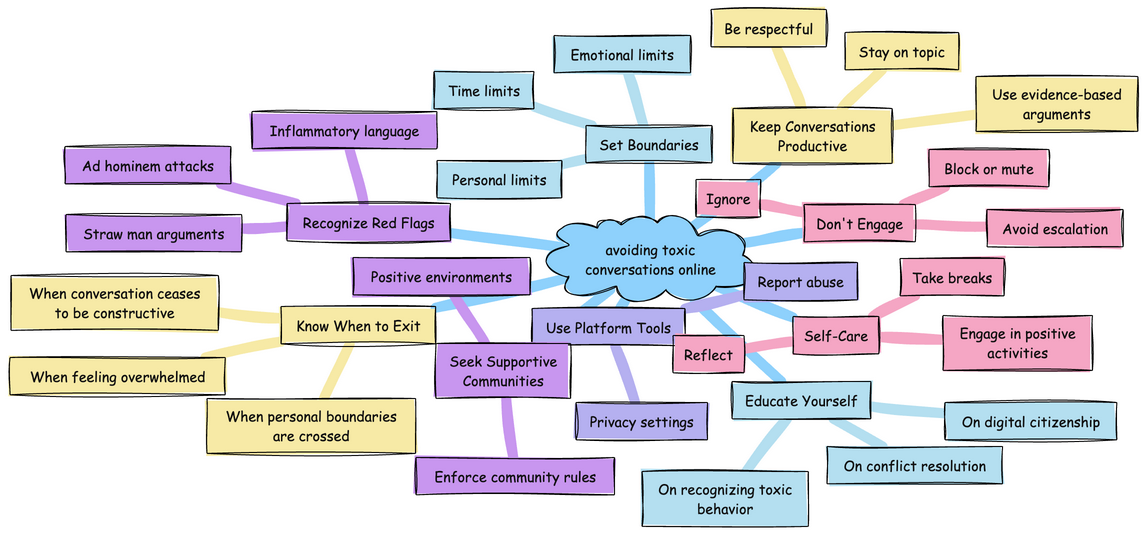

This notebook showcases how Cleanlab can help you find and fix such mistakes in such a dataset. We use the [Civil Comments dataset](https://www.tensorflow.org/datasets/catalog/civil_comments), originated from the comments section on independent news sites.

The Civil Comments dataset is a diverse collection of user comments, covering many topics and discussions and reflecting the varied nature of online discourse.

[Jigsaw](https://jigsaw.google.com/), a unit within Google that explores threats to open societies, extended this dataset by have a team of data annotators label the examples in this dataset for: toxicity, identity mentions, as well as covert offensiveness.
The annotations in this dataset provide valuable insights into the prevalence and nature of harmful behavior online.

Here we specifically focus on the annotations of toxicity levels in user comments, but the same ideas demonstrated in this notebook can be applied to other AI safety annotations for any text dataset. Each comment is labeled with a toxicity score indicating the degree of toxicity or offensiveness exhibited in the comment. This annotation enables researchers to analyze patterns of toxic behavior and develop models for detecting and mitigating toxicity in online conversations, or can be used to filter the unsafe content from this dataset prior to model training.

## Installing and import dependencies

In [ ]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras
!pip install -q cleanlab-studio

In [ ]:
!pip install -q datasets

In [ ]:
import keras_nlp
import keras
import tensorflow as tf
import os
import pandas as pd

keras.utils.set_random_seed(42)

## Load Dataset


We obtain the Jigsaw dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/civil_comments), which provides preprocessed and ready-to-use datasets for machine learning tasks.

In [ ]:
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('civil_comments', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/civil_comments/CivilComments/1.2.4.incompleteG8F1CB/civil_comments-train.t…

Generating validation examples...:   0%|          | 0/97320 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/civil_comments/CivilComments/1.2.4.incompleteG8F1CB/civil_comments-validat…

Generating test examples...:   0%|          | 0/97320 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/civil_comments/CivilComments/1.2.4.incompleteG8F1CB/civil_comments-test.tf…

Dataset civil_comments downloaded and prepared to /root/tensorflow_datasets/civil_comments/CivilComments/1.2.4. Subsequent calls will reuse this data.


## Dataset Structure

A sample of Jigsaw Civil Comments Dataset structure with columns would look like below.

The `text` column likely contains the actual text of the comment, while the other columns provide information about the degree of `toxicity`, `severe toxicity`, and `obscenity` present in the comment.


You can explore more about the dataset from the Dataframe below.

| text                                                                                                               | toxicity | severe_toxicity | obscene  | threat | insult  | identity_attack | sexual_explicit |
|--------------------------------------------------------------------------------------------------------------------|----------|-----------------|----------|--------|---------|-----------------|-----------------|
| Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way! |        0 |               0 |        0 |      0 |       0 |               0 |               0 |
| haha you guys are a bunch of losers.                                                                               | 0.893617 |        0.021277 |        0 |      0 | 0.87234 |        0.021277 |               0 |
| This is such an urgent design problem; kudos to you for taking it on. Very impressive!                             |        0 |               0 |        0 |      0 |       0 |               0 |               0 |
| Is this something I'll be able to install on my site? When will you be releasing it?                               |        0 |               0 |        0 |      0 |       0 |               0 |               0 |
| hahahahahahahahhha suck it.                                                                                        | 0.457627 |        0.050847 | 0.305085 |        |         |                 |                 |

In [ ]:
df = pd.DataFrame(ds.take(1000))

In [ ]:
def mp(x):
    return x.numpy()
df = df.map(mp)
df

,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,toxicity
0,153145,b'2016-11-29 17:23:57.762283+00',b'634903',0.0,0.0,0.0,0,b'',b'54',0.0,0.0,"b""btw, Globe, your new comment section is lame...",0.0,0.2
1,379147,b'2017-09-19 03:02:05.207449+00',b'5977874',0.0,0.0,0.0,5977787,"b""I get the impression that Boeing is very af...",b'54',0.0,0.0,"b""If at first you don't succeed...try again: h...",0.0,0.0
2,342612,b'2017-06-10 06:32:21.121964+00',b'5390534',0.0,0.7,0.0,5388737,"b""Here's a vote for Comey to be prosecuting fo...",b'55',0.0,0.0,"b""You don't understand what leaking is. By th...",0.0,0.7
3,163084,b'2017-01-20 23:46:35.985660+00',b'871483',0.0,0.0,0.0,870487,"b""Excuse me, but what religious freedom are yo...",b'53',0.0,0.0,b'duties come before rights.\nthey have a duty...,0.0,0.0
4,161284,b'2017-01-11 19:39:41.734415+00',b'825427',0.0,0.0,0.0,825241,b'Who thought it would be a good idea to put R...,b'22',0.0,0.0,b'Based upon the activities of the OHA I have ...,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,351199,b'2017-07-03 20:38:01.662587+00',b'5522278',0.0,0.0,0.0,0,b'',b'102',0.0,0.0,b'Emperor Nero reincarnate.',0.0,0.0
996,154860,b'2016-12-06 16:17:41.283990+00',b'669270',0.0,0.0,0.0,0,b'',b'54',0.0,0.0,b'No question about it. It should be referred ...,0.0,0.0
997,160869,b'2017-01-12 01:54:34.698581+00',b'827390',0.0,0.0,0.0,0,b'',b'21',0.0,0.0,"b""Official global population estimate for pola...",0.0,0.0
998,145440,b'2016-09-07 18:17:30.262194+00',b'464265',0.0,0.0,0.0,464081,b'My thoughts are these people that profited d...,b'13',0.0,0.0,b'Finally:\n\n The names would be easy to find...,0.0,0.0


In [ ]:
import numpy as np
for col, dtype in df.dtypes.items():
    if dtype == object:  # Only process byte object columns.
        df[col] = df[col].apply(lambda x: x.decode("utf-8"))

df.head()

,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,toxicity
0,153145,2016-11-29 17:23:57.762283+00,634903,0.0,0.0,0.0,0,,54,0.0,0.0,"btw, Globe, your new comment section is lame. ...",0.0,0.2
1,379147,2017-09-19 03:02:05.207449+00,5977874,0.0,0.0,0.0,5977787,I get the impression that Boeing is very afra...,54,0.0,0.0,If at first you don't succeed...try again: htt...,0.0,0.0
2,342612,2017-06-10 06:32:21.121964+00,5390534,0.0,0.7,0.0,5388737,Here's a vote for Comey to be prosecuting for ...,55,0.0,0.0,You don't understand what leaking is. By the ...,0.0,0.7
3,163084,2017-01-20 23:46:35.985660+00,871483,0.0,0.0,0.0,870487,"Excuse me, but what religious freedom are you ...",53,0.0,0.0,duties come before rights.\nthey have a duty t...,0.0,0.0
4,161284,2017-01-11 19:39:41.734415+00,825427,0.0,0.0,0.0,825241,Who thought it would be a good idea to put Row...,22,0.0,0.0,Based upon the activities of the OHA I have al...,0.0,0.0


In [ ]:
def fn(x):
  if x>0.3: return 1
  return 0
df['toxicity'] = df['toxicity'].apply(fn)
df.head()

,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,toxicity
0,153145,2016-11-29 17:23:57.762283+00,634903,0.0,0.0,0.0,0,,54,0.0,0.0,"btw, Globe, your new comment section is lame. ...",0.0,0
1,379147,2017-09-19 03:02:05.207449+00,5977874,0.0,0.0,0.0,5977787,I get the impression that Boeing is very afra...,54,0.0,0.0,If at first you don't succeed...try again: htt...,0.0,0
2,342612,2017-06-10 06:32:21.121964+00,5390534,0.0,0.7,0.0,5388737,Here's a vote for Comey to be prosecuting for ...,55,0.0,0.0,You don't understand what leaking is. By the ...,0.0,1
3,163084,2017-01-20 23:46:35.985660+00,871483,0.0,0.0,0.0,870487,"Excuse me, but what religious freedom are you ...",53,0.0,0.0,duties come before rights.\nthey have a duty t...,0.0,0
4,161284,2017-01-11 19:39:41.734415+00,825427,0.0,0.0,0.0,825241,Who thought it would be a good idea to put Row...,22,0.0,0.0,Based upon the activities of the OHA I have al...,0.0,0


In [ ]:
df.to_csv('jigsaw.csv')

## Data Curation using Cleanlab Studio

Cleanlab Studio is a powerful tool designed to help you improve the quality of your data for machine learning projects. It tackles the challenge of messy real-world data, which often contains errors, inconsistencies, and biases that can lead to poor model performance.
Cleanlab Studio contains a novel data-centric AI system that can automatically detect problems in datasets and suggest remedies.

Now that we have our dataset, let’s load it into Cleanlab Studio and conduct our analysis.



In [ ]:
from cleanlab_studio import Studio

# you can find your Cleanlab Studio API key by going to studio.cleanlab.ai/upload,
# clicking "Upload via Python API", and copying the API key there

API_KEY = "YOUR API KEY"

studio = Studio(API_KEY)

Let's load the Jigsaw dataset into Cleanlab Studio and create a Project which will automatically detect issues with this dataset.

### Load data into Cleanlab Studio

In [ ]:
dataset_id = studio.upload_dataset('jigsaw.csv', dataset_name="jigsaw")

Uploading dataset...: 100%|██████████|
Ingesting Dataset...: 100%|██████████|


### Launch a Project

In [ ]:
project_id = studio.create_project(
    dataset_id=dataset_id,
    project_name="jigsaw",
    modality="text",
    task_type="multi-class",
    model_type="fast",
    label_column='toxicity'
)
print(f"Project successfully created and training has begun! project_id: {project_id}")

Text column not supplied. Using best guess text
Project successfully created and training has begun! project_id: 42c1eb38f4e247778c026fc9022ae4d7


> Note: For big datasets, this next cell may take a long time to execute while Cleanlab’s AI model is training. If your Jupyter notebook has timed out during this process, you can resume work by re-running the below cell (which should return instantly if the project has completed training). You don't create a new project.

In [ ]:
cleanset_id = studio.get_latest_cleanset_id(project_id)
print(f"cleanset_id: {cleanset_id}")
project_status = studio.wait_until_cleanset_ready(cleanset_id)

cleanset_id: 5b10408b233d4ce6b001af5232a37383


Cleanset Progress: \ Step 53/53, Ready for review!


After fetching the cleaned dataset (called a *Cleanset* for short), let's merge it with our original dataset.

Cleanlab Studio helps resolve multiple data issues like label issues, outliers and ambiguous data. It uses ensemble of models like Gradient Boosted Trees, Neural Networks, Foundation Models, etc. combined with novel data quality algorithms to identify which common problems are present in this dataset. The platform also present AI suggested fixes for these data problems like which data points to remove from the dataset or which labels to correct.

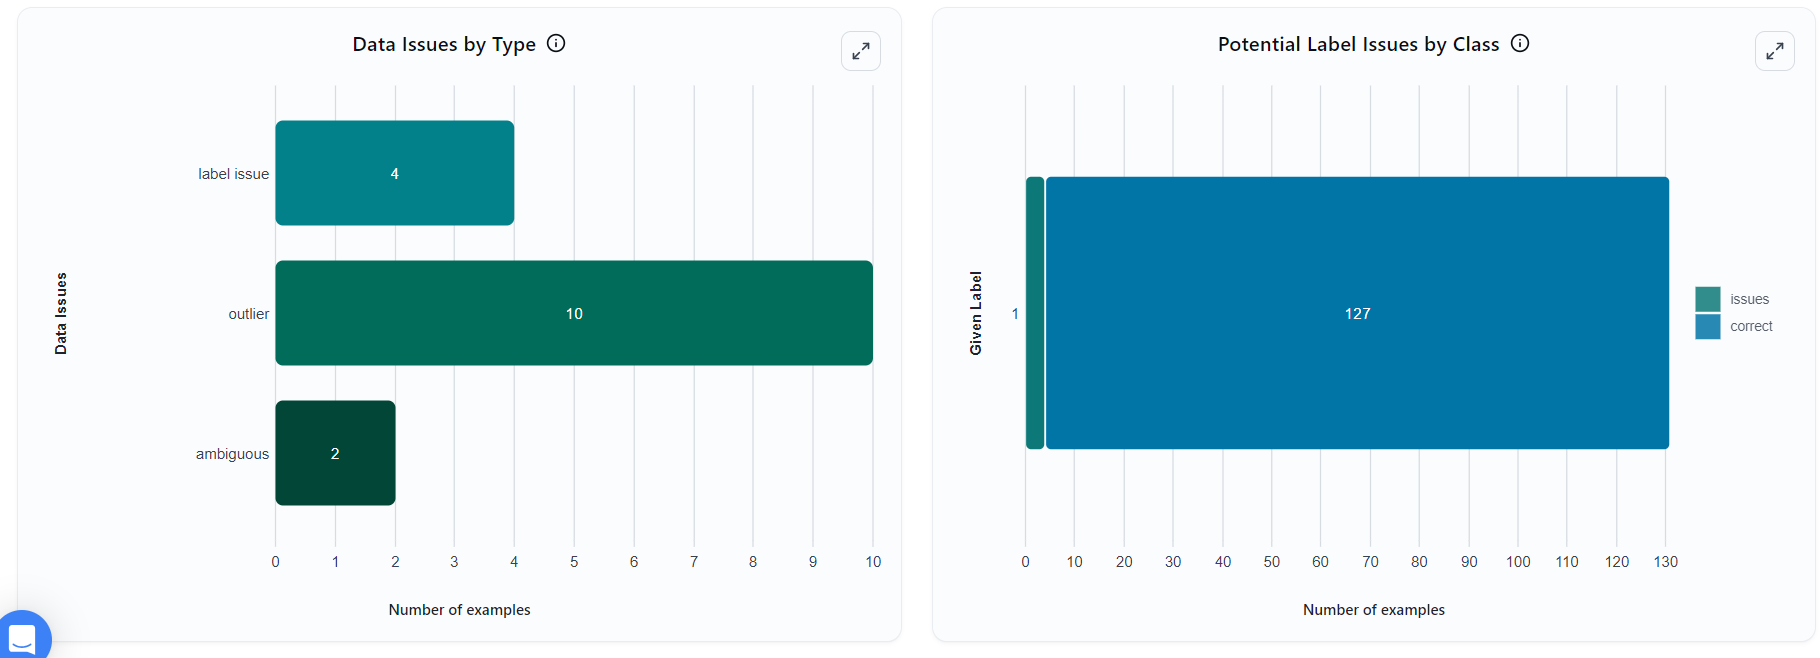

In [ ]:
cleanlab_columns_df = studio.download_cleanlab_columns(cleanset_id)
cleanlab_columns_df.head()

,cleanlab_row_ID,corrected_label,is_label_issue,label_issue_score,suggested_label,suggested_label_confidence_score,is_ambiguous,ambiguous_score,is_well_labeled,is_near_duplicate,near_duplicate_score,near_duplicate_cluster_id,is_outlier,outlier_score,is_initially_unlabeled,has_rare_class,is_empty_text,text_num_characters
0,1,<NA>,False,0.151326,<NA>,0.848674,False,0.998227,False,False,0.503121,<NA>,False,0.010710,False,False,False,216
1,2,<NA>,False,0.125007,<NA>,0.874993,False,0.995130,False,False,0.226294,<NA>,False,0.027774,False,False,False,171
2,3,<NA>,False,0.422958,<NA>,0.577042,False,0.829061,False,False,0.533229,<NA>,False,0.009060,False,False,False,353
3,4,<NA>,False,0.011410,<NA>,0.988590,False,0.963953,False,False,0.223576,<NA>,False,0.021266,False,False,False,72
4,5,<NA>,False,0.057661,<NA>,0.942339,False,0.980173,False,False,0.357548,<NA>,False,0.014321,False,False,False,173


In [ ]:
df = pd.read_csv('jigsaw.csv')
combined_dataset_df = df.merge(cleanlab_columns_df, left_index=True, right_on="cleanlab_row_ID")
combined_dataset_df.rename(columns={"toxicity": "given_label"}, inplace=True)

By using Cleanlab studio, we can identify the given label correctness (toxicity) in our dataset along with the other recommended corrections by Cleanlab Studio like Near duplicates in dataset etc.

In [ ]:
DATASET_COLUMNS = df.columns.drop("toxicity").tolist()
samples_ranked_by_label_issue_score = combined_dataset_df.sort_values("label_issue_score", ascending=False)

columns_to_display = DATASET_COLUMNS + ["label_issue_score", "is_label_issue", "given_label", "suggested_label"]
display(samples_ranked_by_label_issue_score.head(5)[columns_to_display])

,Unnamed: 0,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,label_issue_score,is_label_issue,given_label,suggested_label
241,242,319096,2017-03-15 06:44:47.834860+00,5006354,0.0,0.0,0.0,0,NaN,54,0.0,0.0,My parents were the most incredibly resilient ...,0.0,0.995842,True,0,0
583,584,165935,2017-02-09 01:25:27.923983+00,969616,0.0,0.0,0.0,0,NaN,54,0.0,0.0,Advanced dementia and the possibility of starv...,0.0,0.987626,True,0,0
774,775,358665,2017-07-24 19:00:09.933198+00,5649970,0.0,0.0,0.0,5649291,I see the TSX just dropped over 50 points so ...,54,0.0,0.0,"CR: ""I see the TSX just dropped over 50 points...",0.0,0.985476,True,0,0
24,25,327293,2017-04-16 18:08:34.522863+00,5139762,0.0,0.0,0.0,5139614,A nice picture of Tulsi and her mentor Jane Fo...,55,0.0,0.0,"Vietnam was an extremely costly war, one that ...",0.0,0.984683,True,0,0
237,238,156365,2016-12-15 14:13:25.958009+00,713170,0.0,0.0,0.0,705926,Let's turn all of our citizens into drug addic...,54,0.0,0.0,"""Let's turn all of our citizens into drug addi...",0.0,0.983719,True,0,0


In [ ]:
samples_ranked_by_ambiguous_score = combined_dataset_df.sort_values("ambiguous_score", ascending=False)

columns_to_display = DATASET_COLUMNS + ["ambiguous_score", "is_ambiguous", "given_label", "suggested_label"]
display(samples_ranked_by_ambiguous_score.head(5)[columns_to_display])

,Unnamed: 0,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,ambiguous_score,is_ambiguous,given_label,suggested_label
963,964,372276,2017-08-31 09:16:25.405738+00,5872468,0.0,0.0,0.0,5869781,CO₂'s radiative effect is only band saturated ...,102,0.0,0.0,Dilution: only 1/2500 of the atmosphere is com...,0.0,1.000000,False,0,<NA>
31,32,347554,2017-06-23 16:41:08.020298+00,5465676,0.0,0.0,0.0,5462097,ms.amylou since you seem to be an expert on ed...,21,0.0,0.0,It would be helpful if we tried to see both si...,0.0,1.000000,False,0,<NA>
418,419,374368,2017-09-06 21:25:37.565928+00,5910128,0.0,0.0,0.0,5904446,Trevorlittle is Trevor Siemian when he plays c...,102,0.0,0.0,"Man, you're just a overflowing jug of optimism...",0.0,1.000000,False,0,<NA>
163,164,320117,2017-03-17 16:52:37.363282+00,5018236,0.0,0.0,0.0,5018166,Read through the article in the link that was ...,54,0.0,0.0,FACT CHECK FALSE,0.0,1.000000,False,0,<NA>
77,78,329017,2017-04-25 12:07:36.115950+00,5176008,0.0,0.0,0.0,5175049,"I disagree, they labeled an undefined term in...",54,0.0,0.0,Oh the horror. Oh the hyperbole.,0.0,0.999998,False,0,<NA>


In [ ]:
samples_ranked_by_outlier_score = combined_dataset_df.sort_values("outlier_score", ascending=False)

columns_to_display = DATASET_COLUMNS + ["outlier_score", "is_outlier", "given_label", "suggested_label"]
display(samples_ranked_by_outlier_score.head(5)[columns_to_display])

,Unnamed: 0,article_id,created_date,id,identity_attack,insult,obscene,parent_id,parent_text,publication_id,severe_toxicity,sexual_explicit,text,threat,outlier_score,is_outlier,given_label,suggested_label
266,267,316310,2017-03-02 19:12:23.522824+00,1067617,0.0,0.0,0.0,1066602,They are not being charged for illegal entry i...,54,0.0,0.0,"They are being turned over to Border Services,...",0.0,0.719897,True,0,0
636,637,144327,2016-08-23 23:57:35.251063+00,444860,0.0,0.0,0.0,444350,What is good about this grandstand religious d...,21,0.0,0.0,If you don't talk to the people the man's talk...,0.0,0.658124,True,0,0
367,368,381142,2017-09-23 17:01:13.372781+00,6006998,0.0,0.2,0.0,6006195,"The white house is a thug free zone, Trump is ...",102,0.0,0.0,How could the White House be thug free when Dr...,0.0,0.581994,True,0,0
106,107,322630,2017-03-28 08:11:03.591038+00,5063513,0.0,0.0,0.0,0,NaN,54,0.0,0.0,One thing that I've learned over many years is...,0.0,0.508039,True,0,1
572,573,353118,2017-07-09 05:43:08.006149+00,5557805,0.0,0.3,0.0,0,NaN,105,0.0,0.0,Or attempt to shoot one down and fail to do so...,0.4,0.502865,True,1,0


After analyzing the dataset consisting of **1000** samples, we discovered that there were **79** data points that were incorrectly labeled as safe, **16** data points that were marked as outliers, and **27** data points that were classified as ambiguous in nature. It's important to address these inaccuracies in order to ensure the reliability and accuracy of the data set.

Further, we take the label correction suggestions from Cleanlab Studio and also filter out the recommended data points containing `outlier`, `ambiguous` and `near duplicates`.

In [ ]:
import numpy as np
corrected_label = np.where(combined_dataset_df["is_label_issue"],
                           combined_dataset_df["suggested_label"],
                           combined_dataset_df["given_label"])
rows_to_exclude = combined_dataset_df["is_outlier"] | combined_dataset_df["is_ambiguous"]
near_duplicates_to_exclude = combined_dataset_df['is_near_duplicate'] & combined_dataset_df['near_duplicate_cluster_id'].duplicated(keep='first')

rows_to_exclude |= near_duplicates_to_exclude
fixed_dataset = combined_dataset_df[["text"]].copy()

# Add the corrected label column
fixed_dataset["label"] = corrected_label
fixed_dataset = fixed_dataset[~rows_to_exclude]

Now that we have cleaned the data, our next step is to operationalize it using a machine learning model.

This step involves training the model on the processed data and using it to make toxicity predictions for new data.

## KerasNLP
In this notebook, we use KerasNLP to load a pretrained neural network backbone that will be trained on our dataset via finetuning. KerasNLP is a Python library built on top of Keras, specifically designed to simplify Natural Language Processing (NLP) tasks. With its user-friendly interface and comprehensive set of functionalities, KerasNLP empowers developers and researchers to efficiently tackle a wide range of NLP challenges.

### Key Features of KerasNLP:

* Seamless Integration with Keras: KerasNLP seamlessly integrates with Keras, a popular deep learning library, leveraging its robust architecture and extensive ecosystem. This integration allows users to seamlessly combine NLP-specific functionalities with the flexibility and simplicity of Keras, enabling rapid prototyping and experimentation.

* Modular Design: KerasNLP adopts a modular design philosophy, offering a collection of reusable building blocks for common NLP tasks such as text classification, sequence labeling, machine translation, and more. These modular components, including pre-processing utilities, model architectures, and evaluation metrics, streamline the development process and promote code reusability.

* Pre-trained Models and Embeddings: One of the standout features of KerasNLP is its support for pre-trained language models and embeddings. By incorporating pre-trained models such as BERT, GPT, or ELMo, developers can leverage state-of-the-art NLP capabilities without the need for extensive training on domain-specific data. Similarly, KerasNLP provides interfaces for popular word embeddings like Word2Vec, GloVe, and FastText, enabling users to easily incorporate pre-trained embeddings into their models.

* Flexibility and Customization: Despite its focus on simplicity and ease of use, KerasNLP offers a high degree of flexibility and customization. Users can customize model architectures, loss functions, and optimization strategies to suit their specific requirements. Additionally, KerasNLP provides hooks and callbacks for monitoring training progress, performing early stopping, and saving checkpoints, facilitating efficient model training and tuning.

* Community Support and Documentation: KerasNLP benefits from a vibrant community of developers and researchers who contribute to its development and provide support through forums, documentation, and tutorials. The comprehensive documentation and code examples make it easy for users to get started with KerasNLP and explore its capabilities for various NLP tasks.

## Using DeBERTaV3

For our task, we use the DeBERTaV3 base model with pretrained neural network weights. DeBERTaV3 is a state-of-the-art pre-trained language model (Transformer encoder architecture) developed by Microsoft, building upon the success of previous DeBERTa and BERT models. It's quite efficient and performant, making it an attractive choice for many NLP tasks, where you don't need a many billion parameter LLM.

### Key characteristics of DeBERTaV3:

* Electra-style pre-training: Replaces the Mask Language Modeling (MLM) objective with Replaced Token Detection (RTD), leading to more efficient training with less data.
* Gradient-disentangled embedding sharing: A novel method that overcomes the limitations of vanilla embedding sharing in Electra, further enhancing training efficiency and model quality.
* State-of-the-art performance: Achieves a new state-of-the-art average score of 91.37% on the GLUE benchmark, surpassing previous models like DeBERTa and Electra.

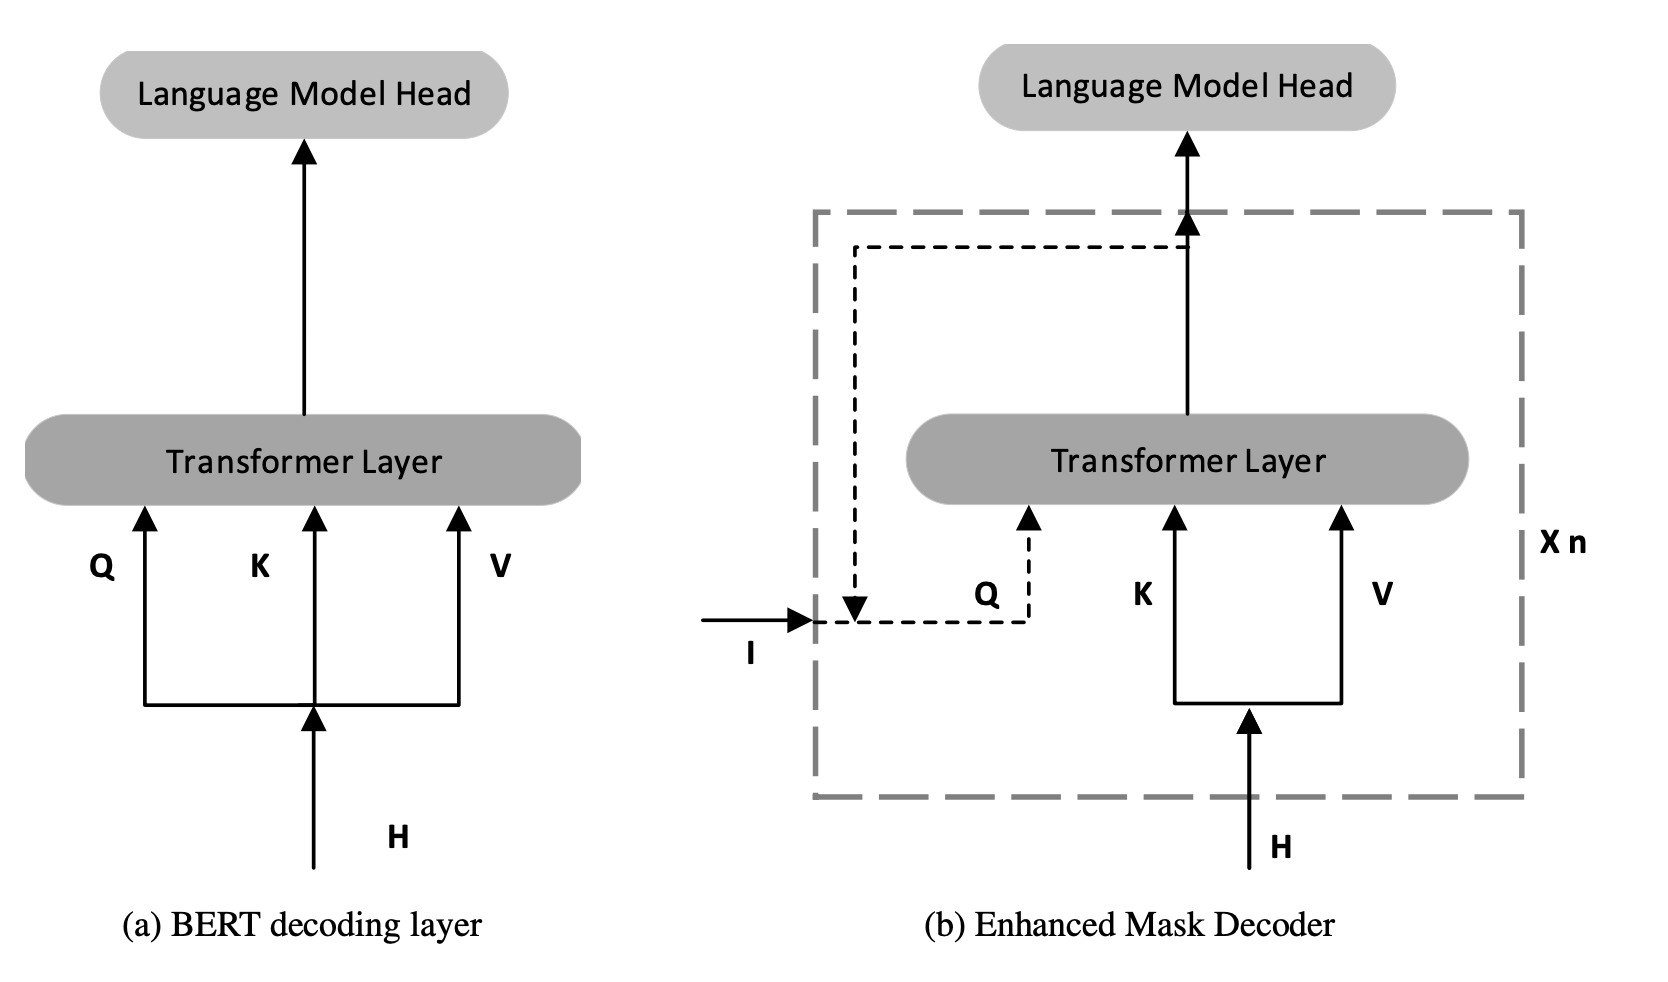

## Training DeBERTaV3 with our cleaned dataset


First, we separate features (text) and labels (toxicity) corresponding to our Machine Learning task. Then, we fine-tune our neural network (DebertaV3Classifier) from the keras_nlp library to fit the data, and we demonstrate how to use the trained model to predict the toxicity of new text input.

In [ ]:
# Some hyperparameters to set
BATCH_SIZE = 4
EPOCHS = 3

In [ ]:
# Prepare data for ML 
features = fixed_dataset.text
labels = fixed_dataset.label

# Load pretrained neural network backbone 
classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
    "deberta_v3_base_en",
    num_classes=2,
    activation='sigmoid',
)
# Fine-tune the network on our data 
classifier.fit(x=features,y=labels.astype(float),batch_size=BATCH_SIZE, epochs=EPOCHS)

100%|██████████| 540/540 [00:00<00:00, 828kB/s]
100%|██████████| 702M/702M [00:21<00:00, 33.9MB/s]
100%|██████████| 424/424 [00:00<00:00, 627kB/s]
100%|██████████| 2.35M/2.35M [00:00<00:00, 4.77MB/s]


Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 222s 176ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8591
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - loss: 0.4086 - sparse_categorical_accuracy: 0.8657
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - loss: 0.4037 - sparse_categorical_accuracy: 0.8657


In [ ]:
classifier.predict(["You are so bad!"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


array([[0.77779865, 0.24594687]], dtype=float32)

## References

* https://keras.io/api/keras_nlp/models/
* https://www.tensorflow.org/datasets/catalog/civil_comments#civil_commentscivilcommentstoxicspans
